# AC-OPF 33-BUS NETWORK
*author: JAMILA*

*09/18/2025*

**Genethic Algorithm (GA)**
---------------------------------------------
Energy Storage Placement and Sizing

In [1]:
import pandapower as pp
import pandapower.networks as pn
import random
import numpy as np
import pandapower.networks as nw
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from prettytable import PrettyTable
import warnings
def create_33_bus_network():
    net = nw.case33bw()
    for i in range(33):
        pp.create_bus(net, vn_kv=12.66, name=f"Bus {i+1}", type='b')
    pp.create_ext_grid(net, bus=0, vm_pu=1.0, name="Grid Connection")

    # Adjust loads to kW and kvar 
    load_data = [
        (1, 100, 60), (2, 90, 40), (3, 120, 80), (4, 60, 30),
        (5, 60, 20), (6, 200, 100), (7, 200, 100), (8, 60, 20),
        (9, 60, 20), (10, 45, 30), (11, 60, 35), (12, 60, 35),
        (13, 120, 80), (14, 60, 10), (15, 60, 20), (16, 60, 25),
        (17, 60, 20), (18, 90, 40), (19, 90, 40), (20, 90, 40),
        (21, 90, 40), (22, 90, 40), (23, 90, 50), (24, 420, 200),
        (25, 420, 200), (26, 60, 25), (27, 60, 25), (28, 60, 20),
        (29, 120, 70), (30, 200, 600), (31, 150, 70), (32, 210, 100),
        (33, 60, 40)
    ]

    for bus, p, q in load_data:
        pp.create_load(net, bus=bus, p_mw=p / 1000, q_mvar=q / 1000, name=f"Load {bus}")
    return net

In [2]:

# Run AC OPF with storage placement and sizing
def run_ac_opf_with_storage(net, solution):
    n_storage = 3                                                               # Number of storage units
    buses = [max(0, min(round(solution[i]), 32)) for i in range(n_storage)]     # Storage placement
    powers = solution[n_storage:2 * n_storage]                                  # Storage power capacities (kW)
    energies = solution[2 * n_storage:3 * n_storage]                            # Storage energy capacities (kWh)
    for idx, bus in enumerate(buses):
        if bus < len(net.bus):
            pp.create_storage(
                net,
                bus=bus,
                p_mw=powers[idx]/1000, 
                max_e_mwh=energies[idx]/1000, 
                soc_percent=50,                 # Initial SOC
                min_e_mwh=0.1,                  # Minimum energy
                efficiency_percent=95.0         # Efficiency
            )

    try:
        pp.runopp(net, numba=False)
    except:
        pp.runpp(net, numba=False)                   

    # Calculate power loss and voltage deviation
    power_loss = net.res_line.pl_mw.sum() * 1000
    voltage_deviation = np.sum(np.abs(1 - net.res_bus.vm_pu))
    return power_loss, voltage_deviation

# Enforce bounds during evaluation
def enforce_bounds(individual):
    n_storage = 3                                               # Number of storage units
    for i in range(n_storage):
        individual[i] = max(0, min(round(individual[i]), 32))   # Constrain bus indices
    for i in range(n_storage, n_storage*2):
        individual[i] = max(0, min(round(individual[i]), 100))   
    for i in range(n_storage*2, n_storage*3):
        individual[i] = max(0, min(round(individual[i]), 500))   
    return individual

# Evaluate fitness
def evaluate_fitness(individual):
    individual = enforce_bounds(individual)
    net = create_33_bus_network()
    power_loss, voltage_deviation = run_ac_opf_with_storage(net, individual)
    placement_penalty = len(individual[:3]) - len(set(individual[:3]))
    cost = (0.5 * (power_loss) +
            0.5 * (voltage_deviation) +
            10 * placement_penalty)  # Add penalty term
    return cost,

In [13]:
# Define Genetic Algorithm (GA) parameters
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define toolbox
toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 32)             # Bus index (placement)
toolbox.register("attr_float_power", random.uniform, 50, 100)   # Power capacity in kW
toolbox.register("attr_float_energy", random.uniform, 50, 500)  # Energy capacity in kWh

# Combine placement and sizing in individuals
toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (toolbox.attr_int, toolbox.attr_int, toolbox.attr_int,                              # Placement
     toolbox.attr_float_power, toolbox.attr_float_power, toolbox.attr_float_power,      # Power
     toolbox.attr_float_energy, toolbox.attr_float_energy, toolbox.attr_float_energy),  # Energy
    n=1
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operations
toolbox.register("evaluate", evaluate_fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.35)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.025)
toolbox.register("select", tools.selTournament, tournsize=3)

warnings.simplefilter(action='ignore', category=FutureWarning)# Initialize statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

# Run the Genetic Algorithm
hof = tools.HallOfFame(1)
population = toolbox.population(n=9)
pop, logbook = algorithms.eaSimple(
    population, toolbox, cxpb=0.35, mutpb=0.15, ngen=100, stats=stats, halloffame=hof, verbose=True
)
min_values = [gen["min"] for gen in logbook]
max_values = [gen["max"] for gen in logbook]
ave_values = [gen["avg"] for gen in logbook]
std_values = [gen["std"] for gen in logbook]

# Extract the best individual
best_individual = tools.selBest(population, k=1)[0]
print("--" * 40)
print("Best solution for optimal placement:", np.round(best_individual[:3]))
print("Best solution for optimal power sizing (kW):", np.round(best_individual[3:6], 2))
print("Best solution for optimal energy sizing (kWh):", np.round(best_individual[6:], 2))
print("Fitness value:", best_individual.fitness.values)

c:\Users\novin\AppData\Local\Programs\Python\Python313\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\novin\AppData\Local\Programs\Python\Python313\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg           	std         	min           	max           
0  	9     	[551.56770702]	[10.2100438]	[535.16708718]	[572.24682998]
1  	7     	[546.19897101]	[3.36606109]	[542.85859201]	[551.14106711]
2  	4     	[545.23985986]	[6.94695451]	[533.85733003]	[559.04912145]
3  	5     	[541.01140191]	[5.37950322]	[533.85733003]	[552.5291735] 
4  	0     	[537.3458744] 	[3.01337718]	[533.85733003]	[542.85859201]
5  	0     	[534.61795989]	[1.64732813]	[533.85733003]	[539.04065289]
6  	4     	[533.85733003]	[0.]        	[533.85733003]	[533.85733003]
7  	2     	[533.85733003]	[0.]        	[533.85733003]	[533.85733003]
8  	6     	[533.85733003]	[0.]        	[533.85733003]	[533.85733003]
9  	4     	[533.85733003]	[0.]        	[533.85733003]	[533.85733003]
10 	5     	[533.85733003]	[0.]        	[533.85733003]	[533.85733003]
11 	3     	[533.86307382]	[0.0162459] 	[533.85733003]	[533.90902416]
12 	3     	[534.08073307]	[0.61381427]	[533.85733003]	[535.81626332]
13 	2     	[533.85733003]	[0.]    

In [7]:
import pandapower as pp
import pandapower.networks as nw
import numpy as np
from pyswarm import pso
import matplotlib.pyplot as plt
from pyswarms.utils.functions.single_obj import sphere
from pyswarms.utils.plotters import plot_cost_history
import warnings
warnings.filterwarnings('ignore')

def create_33_bus_network():
    net = nw.case33bw()
    for i in range(33):
        pp.create_bus(net, vn_kv=12.66, name=f"Bus {i+1}", type='b')
    pp.create_ext_grid(net, bus=0, vm_pu=1.0, min_p_mw=0, max_p_mw=1/1000, min_q_mvar=0, max_q_mvar=1/1000, name="Grid Connection(PSO)")
    load_data = [
        (1, 100, 60), (2, 90, 40), (3, 120, 80), (4, 60, 30),
        (5, 60, 20), (6, 200, 100), (7, 200, 100), (8, 60, 20),
        (9, 60, 20), (10, 45, 30), (11, 60, 35), (12, 60, 35),
        (13, 120, 80), (14, 60, 10), (15, 60, 20), (16, 60, 25),
        (17, 60, 20), (18, 90, 40), (19, 90, 40), (20, 90, 40),
        (21, 90, 40), (22, 90, 40), (23, 90, 50), (24, 420, 200),
        (25, 420, 200), (26, 60, 25), (27, 60, 25), (28, 60, 20),
        (29, 120, 70), (30, 200, 600), (31, 150, 70), (32, 210, 100),
        (33, 60, 40)
    ]

    for bus, p, q in load_data:
        pp.create_load(net, bus=bus, p_mw=p / 1000, q_mvar=q / 1000, name=f"Load {bus}")
    return net
# Run AC OPF and evaluate the solution
def run_ac_opf_with_storage(net, solution):
    n_storage = 3
    buses = [max(0, min(int(round(solution[i])), 32)) for i in range(n_storage)]
    powers = solution[n_storage:2 * n_storage]
    energies = solution[2 * n_storage:3 * n_storage]
    for idx, bus in enumerate(buses):
        if bus < len(net.bus):
            pp.create_storage(
                net,
                bus=bus,
                p_mw=powers[idx] / 1000,
                max_e_mwh=energies[idx] / 1000,
                soc_percent=50,
                min_e_mwh=0.1,
                min_p_mw=-10 / 1000,
                max_p_mw=10 / 1000,
                min_q_mvar=-10 / 1000,
                max_q_mvar=10 / 1000,
                efficiency_percent=95.0
            )
    try:
        pp.runopp(net, numba=False)
    except:
        pp.runpp(net, numba=False)
    power_loss = net.res_line.pl_mw.sum() * 1000
    voltage_deviation = np.sum(np.abs(1 - net.res_bus.vm_pu))
    return power_loss, voltage_deviation

# Fitness function for PSO
def evaluate_fitness(solution):
    net = create_33_bus_network()
    power_loss, voltage_deviation = run_ac_opf_with_storage(net, solution)
    placement_penalty = len(solution[:3]) - len(set(solution[:3]))
    cost = (0.5 * (power_loss) +
            0.5 * (voltage_deviation) +
            10 * placement_penalty)
    return cost

# Define bounds for PSO
n_storage = 3
lower_bounds = [0] * n_storage + [50] * n_storage + [50] * n_storage
upper_bounds = [32] * n_storage + [100] * n_storage + [500] * n_storage

# Store fitness values during iterations
fitness_log = []
current_best_fitness = np.inf  

def evaluate_fitness_with_logging(solution):
    global current_best_fitness
    fitness = evaluate_fitness(solution)
    if fitness < current_best_fitness:
        current_best_fitness = fitness
        fitness_log.append(fitness)
    return fitness

Iteration = 500
# Inertia coefficient (w), Particle's cognitive coefficient (c1), Swarm's social coefficient (c2)
omega, phip, phig = 0.5, 0.5, 0.9    

def run_pso():
    global fitness_log, current_best_fitness
    fitness_log = [] 
    current_best_fitness = np.inf  
    best_solution, best_cost = pso(evaluate_fitness_with_logging, lower_bounds, upper_bounds,
                                swarmsize=10, maxiter=Iteration, debug=True, omega=omega,
                                phip=phip, phig=phig)
    return best_solution, best_cost

# Run PSO
print('='*40)
best_solution, best_cost = run_pso()
print("Best solution:", best_solution)
print("Best cost:", best_cost)
print('='*40)


No constraints given.


New best for swarm at iteration 1: [ 25.06087851   0.          20.70729697  51.0748563   76.23049674
  85.67515274 446.06239736 190.44512337  50.        ] 529.6199899773435
New best for swarm at iteration 1: [ 18.31399006  21.18590587   0.          50.          90.54321493
  83.37947413 500.          50.          50.        ] 523.9009763771637
Best after iteration 1: [ 18.31399006  21.18590587   0.          50.          90.54321493
  83.37947413 500.          50.          50.        ] 523.9009763771637
Best after iteration 2: [ 18.31399006  21.18590587   0.          50.          90.54321493
  83.37947413 500.          50.          50.        ] 523.9009763771637
Best after iteration 3: [ 18.31399006  21.18590587   0.          50.          90.54321493
  83.37947413 500.          50.          50.        ] 523.9009763771637
New best for swarm at iteration 4: [ 18.38834336  20.38255803   0.          50.          95.92069056
  90.67480873 500.          50.          50.        ] 523.880045690

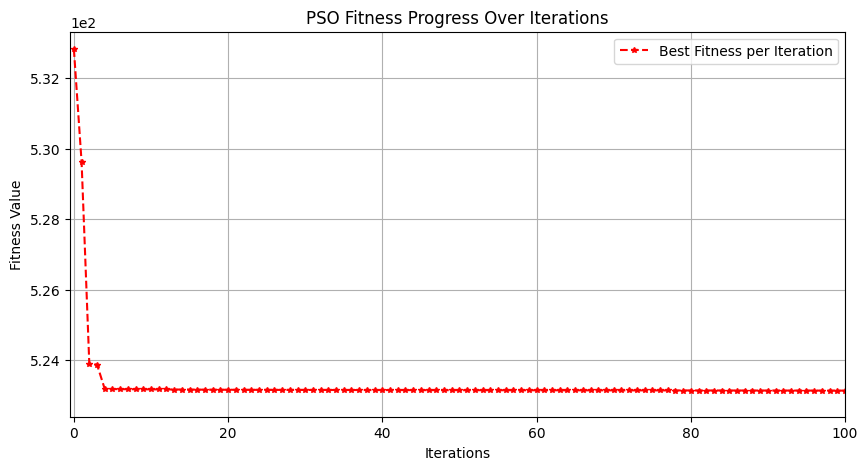

Best solution for optimal placement (bus indices): [19. 19.  1.]
Best solution for optimal power sizing (kW): [50.   50.   99.25]
Best solution for optimal energy sizing (kWh): [495.54  50.21  50.  ]
Best fitness value (cost): 522.8967239249961


In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(fitness_log, label='Best Fitness per Iteration', marker='*',markersize =4, color='r', linestyle = '--')
plt.title('PSO Fitness Progress Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fitness Value')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim(-0.5, 100)
plt.grid(True)
plt.legend()
plt.show()
print('='*80)
print('='*80)
print("Best solution for optimal placement (bus indices):", np.round(best_solution[:n_storage])+1)
print("Best solution for optimal power sizing (kW):", np.round(best_solution[n_storage:2 * n_storage], 2))
print("Best solution for optimal energy sizing (kWh):", np.round(best_solution[2 * n_storage:], 2))
print("Best fitness value (cost):", best_cost)
print('='*80)

# comparative plots for GA vs PSO results

Text(0.5, 1.0, 'Best Fitness: GA vs PSO')

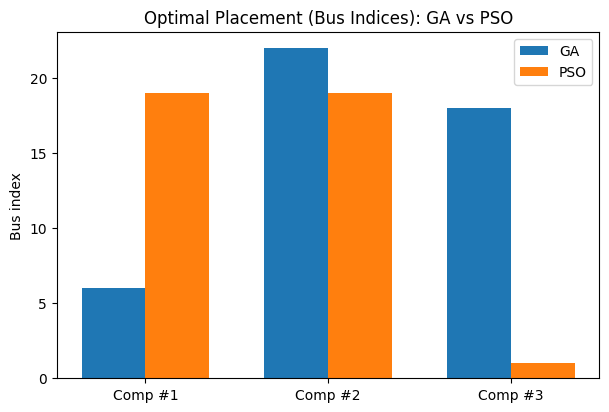

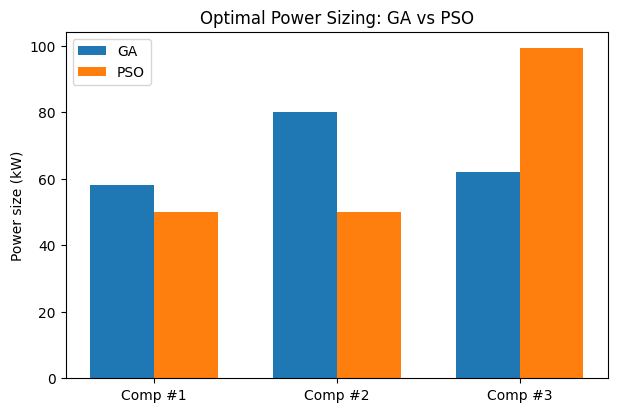

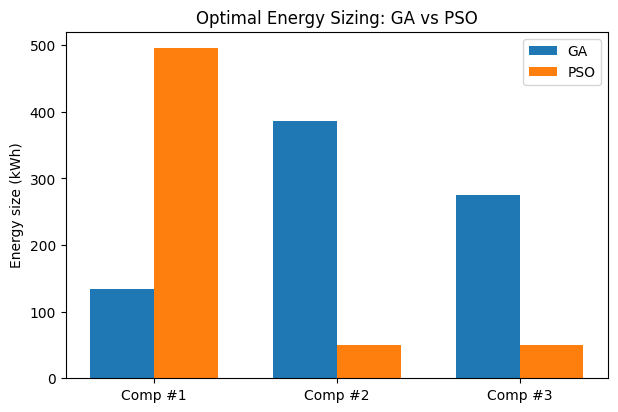

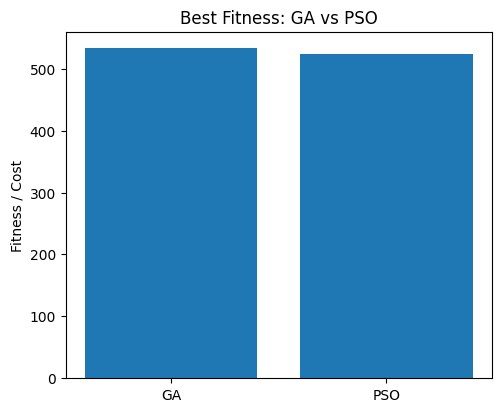

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Raw inputs from the user ----
GA = {
    "placement": np.array([6, 22, 18], dtype=float),
    "power_kw": np.array([58, 80, 62], dtype=float),
    "energy_kwh": np.array([134, 387, 275], dtype=float),
    "fitness": float(532.9296343276901),
}

PSO = {
    "placement": np.array([19., 19., 1.], dtype=float),
    "power_kw": np.array([50., 50., 99.25], dtype=float),
    "energy_kwh": np.array([495.54, 50.21, 50.], dtype=float),
    "fitness": float(522.8967239249961),
}

# Build a tidy DataFrame for summary
df = pd.DataFrame({
    "Component": ["#1", "#2", "#3"],
    "GA_Placement(bus)": GA["placement"],
    "PSO_Placement(bus)": PSO["placement"],
    "GA_Power(kW)": GA["power_kw"],
    "PSO_Power(kW)": PSO["power_kw"],
    "GA_Energy(kWh)": GA["energy_kwh"],
    "PSO_Energy(kWh)": PSO["energy_kwh"],
})
summary = pd.DataFrame({
    "Metric": ["Fitness"],
    "GA": [GA["fitness"]],
    "PSO": [PSO["fitness"]],
})

# 1) Placement comparison
plt.figure(figsize=(7,4.5))
x = np.arange(3)
width = 0.35
plt.bar(x - width/2, GA["placement"], width, label="GA")
plt.bar(x + width/2, PSO["placement"], width, label="PSO")
plt.xticks(x, ["Comp #1", "Comp #2", "Comp #3"])
plt.ylabel("Bus index")
plt.title("Optimal Placement (Bus Indices): GA vs PSO")
plt.legend()

# 2) Power sizing comparison
plt.figure(figsize=(7,4.5))
plt.bar(x - width/2, GA["power_kw"], width, label="GA")
plt.bar(x + width/2, PSO["power_kw"], width, label="PSO")
plt.xticks(x, ["Comp #1", "Comp #2", "Comp #3"])
plt.ylabel("Power size (kW)")
plt.title("Optimal Power Sizing: GA vs PSO")
plt.legend()

# 3) Energy sizing comparison
plt.figure(figsize=(7,4.5))
plt.bar(x - width/2, GA["energy_kwh"], width, label="GA")
plt.bar(x + width/2, PSO["energy_kwh"], width, label="PSO")
plt.xticks(x, ["Comp #1", "Comp #2", "Comp #3"])
plt.ylabel("Energy size (kWh)")
plt.title("Optimal Energy Sizing: GA vs PSO")
plt.legend()

# 4) Fitness comparison
plt.figure(figsize=(5.5,4.5))
methods = ["GA", "PSO"]
fitness_vals = [GA["fitness"], PSO["fitness"]]
plt.bar(methods, fitness_vals)
plt.ylabel("Fitness / Cost")
plt.title("Best Fitness: GA vs PSO")
